<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/pytorch-seq2seq/4_Packed_Padded_Sequences%2C_Masking%2C_Inference_and_BLEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from tqdm import tqdm
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [ ]:

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    v2 = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    v2.set_default_index(0)
    return v2

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                                dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                                dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [ ]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,enc_hid_dim,dec_hid_dim,dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim,emb_dim)
        self.rnn = nn.GRU(emb_dim,enc_hid_dim,bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2,dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self,src,src_len):
        #src = [src len,batch size]
        #src len =[batch size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len,batch size,emb dim]

        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,src_len.to('cpu'),enforce_sorted=False)

        packed_outputs,hidden = self.rnn(packed_embedded)

        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
        outputs,_ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros

        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]

        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer

        #hidden [-2, :, : ] is the last of the forwards RNN
        #hidden [-1, :, : ] is the last of the backwards RNN

        #initial decoder hidden is final hidden state of the forwards and backwards
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim = 1)))

        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]

        return outputs,hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self,enc_hid_dim,dec_hid_dim):
        super(Attention,self).__init__()

        self.attn = nn.Linear((enc_hid_dim *2) + dec_hid_dim,dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim,1,bias = False)
    def forward(self,hidden,encoder_outputs,mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]


        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]

        attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention,dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim,emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2)+ emb_dim,dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2)+dec_hid_dim + emb_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self,input, hidden, encoder_outputs, mask):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        input = input.unsqueeze(0)
        #input = [1,batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden,encoder_outputs,mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1,0,2)
        # encoder_outputs = [ batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a,encoder_outputs)
        #weighted = [batch size,1,enc hid dim * 2]

        weighted = weighted.permute(1,0,2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        #prediction = [batch size, output dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,src_pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx

    def create_mask(self,src):
        mask = (src != self.src_pad_idx).permute(1,0)
        return mask #shape = [batch_size,seq_len]

    def forward(self,src,src_len,trg,teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        mask = self.create_mask(src)

        #mask = [batch size, src len]
        for t in range(1, trg_len):

            #insert input token embedding, previous hidden state, all encoder hidden states
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
x,y = next(iter(train_iter))

In [ ]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
# ENC_HID_DIM = 512
# DEC_HID_DIM = 512
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
PAD_TOKEN = 1
lengths = torch.tensor([len([token for token in sequence if token != PAD_TOKEN]) for sequence in x.T])
SRC_PAD_IDX = de_vocab.get_stoi()['<pad>']



enc = Encoder(INPUT_DIM,ENC_EMB_DIM,ENC_HID_DIM,DEC_HID_DIM,ENC_DROPOUT)
# outputs,hidden = enc(x,lengths)
att = Attention(ENC_HID_DIM,DEC_HID_DIM)
# a = att(hidden,outputs,mask(x))
dec = Decoder(OUTPUT_DIM,DEC_EMB_DIM,ENC_HID_DIM,DEC_HID_DIM,DEC_DROPOUT,att)
# input = y[0,:]
# prediction,hidden,a = dec(input,hidden,outputs,mask(x))
# prediction.shape

model = Seq2Seq(enc,dec,SRC_PAD_IDX).to(device)


In [ ]:
def init_weights(m:nn.Module):
    for name,param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
init_weights(model)

In [ ]:
def count_paramters(model:nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_paramters(model)

15179478

In [ ]:
TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, (src,trg) in enumerate(tqdm(iterator)):
        PAD_TOKEN = 1
        src_len = torch.tensor([len([token for token in sequence if token != PAD_TOKEN]) for sequence in src.T])

        src , trg,src_len = src.to(device),trg.to(device),src_len.to(device)

        optimizer.zero_grad()

        output = model(src, src_len, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, (src,trg) in enumerate(tqdm(iterator)):
            PAD_TOKEN = 1
            src_len = torch.tensor([len([token for token in sequence if token != PAD_TOKEN]) for sequence in src.T])

            src , trg,src_len = src.to(device),trg.to(device),src_len.to(device)

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Epoch: 01 | Time: 1m 25s
	Train Loss: 5.133 | Train PPL: 169.561
	 Val. Loss: 4.837 |  Val. PPL: 126.066


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]


Epoch: 02 | Time: 1m 26s
	Train Loss: 4.242 | Train PPL:  69.577
	 Val. Loss: 4.671 |  Val. PPL: 106.762


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Epoch: 03 | Time: 1m 26s
	Train Loss: 3.897 | Train PPL:  49.231
	 Val. Loss: 4.475 |  Val. PPL:  87.768


100%|██████████| 8/8 [00:02<00:00,  3.83it/s]


Epoch: 04 | Time: 1m 26s
	Train Loss: 3.572 | Train PPL:  35.580
	 Val. Loss: 4.182 |  Val. PPL:  65.512


100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch: 05 | Time: 1m 25s
	Train Loss: 3.230 | Train PPL:  25.282
	 Val. Loss: 3.988 |  Val. PPL:  53.924


100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch: 06 | Time: 1m 25s
	Train Loss: 2.969 | Train PPL:  19.481
	 Val. Loss: 3.826 |  Val. PPL:  45.864


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch: 07 | Time: 1m 26s
	Train Loss: 2.711 | Train PPL:  15.048
	 Val. Loss: 3.742 |  Val. PPL:  42.195


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


Epoch: 08 | Time: 1m 26s
	Train Loss: 2.510 | Train PPL:  12.307
	 Val. Loss: 3.676 |  Val. PPL:  39.470


100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


Epoch: 09 | Time: 1m 26s
	Train Loss: 2.337 | Train PPL:  10.345
	 Val. Loss: 3.665 |  Val. PPL:  39.072


100%|██████████| 8/8 [00:01<00:00,  4.26it/s]

Epoch: 10 | Time: 1m 26s
	Train Loss: 2.177 | Train PPL:   8.818
	 Val. Loss: 3.674 |  Val. PPL:  39.415


In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

| Test Loss: 3.641 | Test PPL:  38.122 |


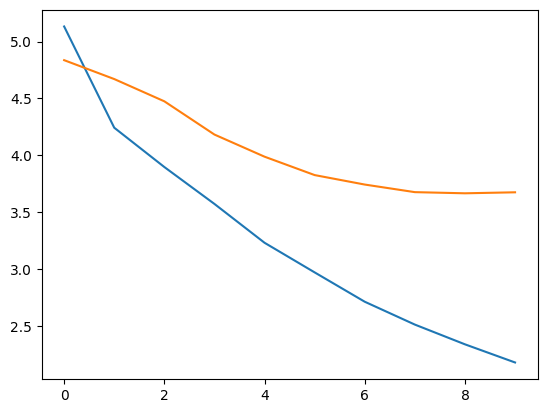

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)

    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-171-ba31e26abe17>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
<ipython-input-171-ba31e26abe17>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks,fontsize = 10)


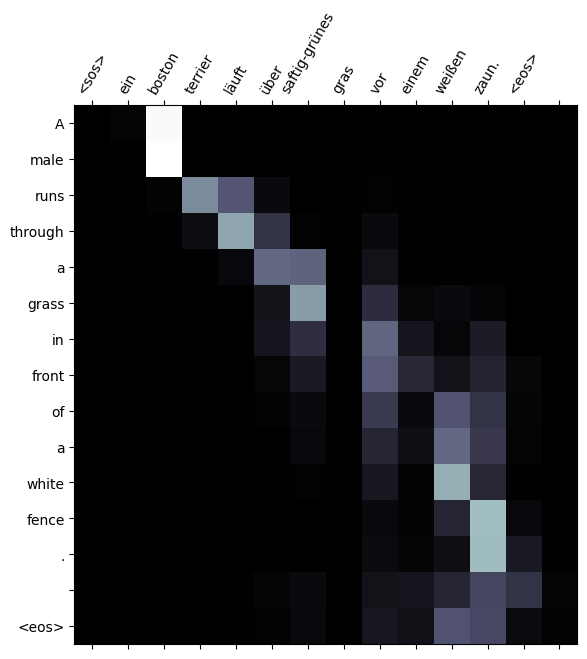

In [ ]:
# Define the translation function
def translate_sentence(model, src_sentence,device, max_len=50):
    model.eval()
    with torch.no_grad():
        if isinstance(src_sentence, str):
            tokens = de_tokenizer(src_sentence)
        else:
            tokens = src_sentence


        tokens = ['<bos>'] + tokens + ['<eos>']
        src_indexes = de_vocab.lookup_indices(tokens)

        src_tensor = torch.tensor(src_indexes).unsqueeze(1).to(device)

        src_len = torch.tensor([len(src_indexes)])

        with torch.no_grad():
            encoder_outputs, hidden = model.encoder(src_tensor, src_len)

        mask = model.create_mask(src_tensor)

        BOS_INDEX = en_vocab.get_stoi()["<bos>"]

        trg_indexes = [BOS_INDEX]

        attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
        for i in range(max_len):

            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            with torch.no_grad():
                output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

            attentions[i] = attention

            pred_token = output.argmax(1).item()

            trg_indexes.append(pred_token)

            if pred_token == en_vocab.get_stoi()["<eos>"]:
                break

    trg_tokens = en_vocab.lookup_tokens(trg_indexes)

    return trg_tokens[1:] , attentions[:len(trg_tokens)-1]


# Define the function to display attention
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)

    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence.split(' ')] + ['<eos>']
    y_ticks = [''] + translation
    ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
    ax.set_yticklabels(y_ticks,fontsize = 10)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# Now you can use these functions to translate and display attention
src_sentence ="Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun."# Replace with your own source sentence tokens
translation, attention=translate_sentence(model, src_sentence, device)

display_attention(src_sentence, translation, attention)


In [ ]:
test_x,test_y = next(iter(test_data))
test_x

tensor([ 24,  31,  19,  32, 102, 219,  52,  12, 188,   0,  16,  17])

In [ ]:
def get_test_data(filepaths): #test_filepaths
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    return raw_de_iter,raw_en_iter



In [ ]:
test_x,test_y = get_test_data(test_filepaths)
src_arr = []
trg_arr = []
for x,y in zip(test_x,test_y):
    src_arr.append(x)
    trg_arr.append(y)

src Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.

trg A mother and her young song enjoying a beautiful day outside.

predicted trg = ['A', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'in', 'the', 'day', '.', '\n', '<eos>']


<ipython-input-171-ba31e26abe17>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
<ipython-input-171-ba31e26abe17>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks,fontsize = 10)


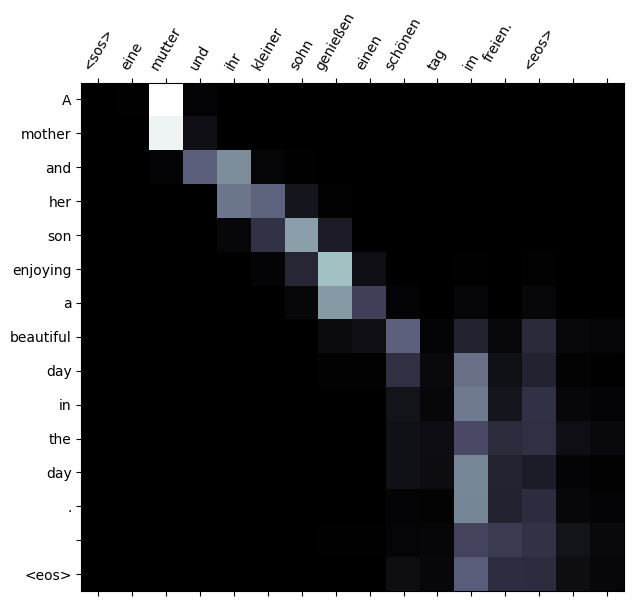

In [ ]:
example_idx = 10
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src Leute, die vor einem Gebäude stehen.

trg People standing outside of a building.

predicted trg = ['People', 'are', 'in', 'front', 'of', 'a', 'building', '.', '\n', '<eos>']


<ipython-input-171-ba31e26abe17>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
<ipython-input-171-ba31e26abe17>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks,fontsize = 10)


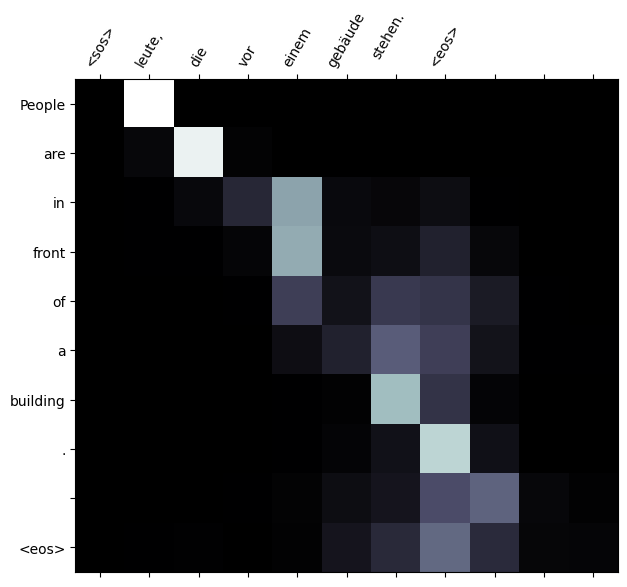

In [ ]:
example_idx = 20
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src Die Person im gestreiften Shirt klettert auf einen Berg.

trg The person in the striped shirt is mountain climbing.

predicted trg = ['The', 'person', 'in', 'a', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '\n', '<eos>']


<ipython-input-171-ba31e26abe17>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
<ipython-input-171-ba31e26abe17>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks,fontsize = 10)


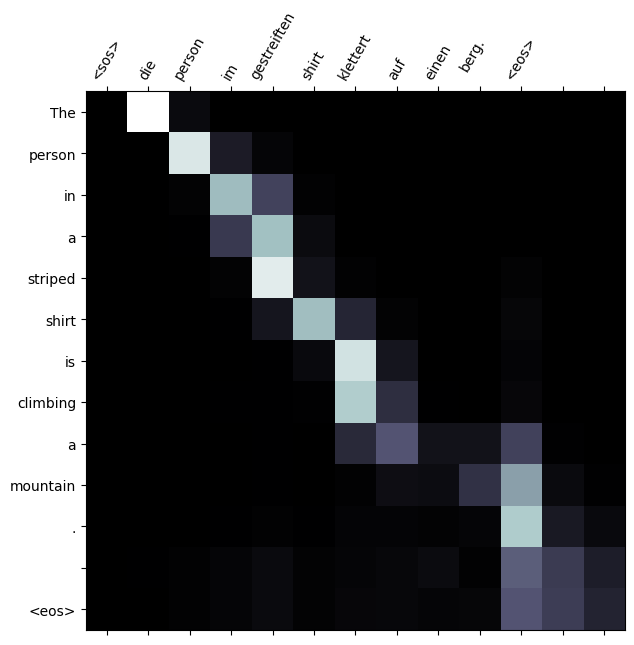

In [ ]:
example_idx = 18
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src Drei Leute sitzen in einer Höhle.

trg Three people sit in a cave.

predicted trg = ['Three', 'people', 'are', 'sitting', 'in', 'a', 'subway', '.', '.', '\n', '<eos>']


<ipython-input-171-ba31e26abe17>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=60,fontsize = 10)
<ipython-input-171-ba31e26abe17>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks,fontsize = 10)


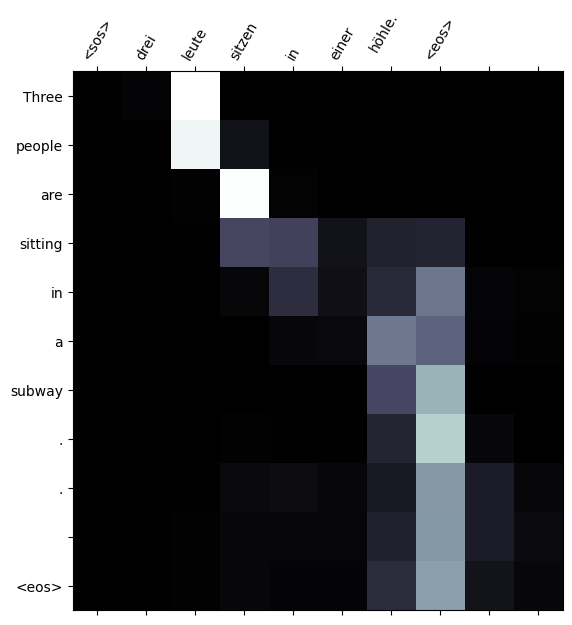

In [ ]:
example_idx = 14
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)